# Ensemble Classifiers for Footprinting
## On all TFs at once

In [78]:
libs <- c(
    'RColorBrewer',
    'ggplot2',
    'xgboost',
    'glmnet',
    'dplyr',
    'tidyr',
    'pROC',
    'stringr',
    'caret',
    'caTools'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

(.packages())

[1] "caTools"      "caret"        "lattice"      "stringr"      "pROC"        
 [6] "tidyr"        "dplyr"        "glmnet"       "foreach"      "Matrix"      
[11] "xgboost"      "ggplot2"      "RColorBrewer" "stats"        "graphics"    
[16] "grDevices"    "utils"        "datasets"     "methods"      "base"

In [3]:
split_data <- function(outcomes,p=0.75) {
    n <- length(outcomes)
    s <- floor(p*n)
    sample_inds <- sample(seq_len(n), size = s)
    return(sample_inds)
}

In [4]:
mattcc <- function(true_classes, predicted_classes) {
        
    pos <- true_classes == 1
    neg <- true_classes == 0
    
    TP <- as.numeric(sum( predicted_classes[pos] == true_classes[pos] ))
    TN <- as.numeric(sum( predicted_classes[neg] == true_classes[neg] ))
    FP <- as.numeric(sum( predicted_classes[pos] != true_classes[pos] ))
    FN <- as.numeric(sum( predicted_classes[neg] != true_classes[neg] )) 
    
    N1 <- TP*TN
    N2 <- FP*FN
    D1 <- TP+FP
    D2 <- TP+FN
    D3 <- TN+FP
    D4 <- TN+FN
    
    N <- N1-N2
    D <- D1*D2*D3*D4
    
    if (D==0) {
        M <- 0
    } else {
        M <- N/sqrt(D)
    }
    
    return(M)
}

mattcc.curve <- function(true.values, pred.probs, num.points=101) {
    threshholds <- seq(from=0, to=1, length.out=num.points)
    thresh.inds <- 1:length(threshholds)

    mattcc.data <- sapply(thresh.inds,
                      function(t) mattcc(true.values,as.numeric(pred.probs>threshholds[t]))
                   )
    return(mattcc.data)
}

In [5]:
ggplotColours <- function(n = 6, h = c(0, 360) + 15){
  if ((diff(h) %% 360) < 1) h[2] <- h[2] - 360/n
  hcl(h = (seq(h[1], h[2], length = n)), c = 100, l = 65)
} 

## Load data

In [6]:
# paul's data frame

# tableName <- "ftClean.Fri.Sep.30.2016-18:02:21.RData"
tableName <- "chr19.all.RData"
directory <- "~/git-repos/BDDS/trenadb/featureTable/lymphoblast"
fullPath <- file.path(directory, tableName)
stopifnot(file.exists(fullPath))
load(fullPath)

# name of big data table
ft.clean <- tbl


# cory's motif to tf-class mapping
tf.fams.file <- "/local/Cory/for_Paul/motif_class_fam"
tf.fams.table <- read.delim(tf.fams.file, stringsAsFactors=FALSE)

## Add TF classes as features

In [7]:
# check overlap of motif names from cory and paul

motif.names.from.cory <- str_replace_all(string=tf.fams.table$ID, pattern="[[:space:]]", repl="")
motif.names.from.paul <- unique(ft.clean$motif)

# motifs not occurring from sample data
from.cory.not.in.paul <- motif.names.from.cory[!(motif.names.from.cory %in% motif.names.from.paul)]

# motifs not mapped in cory's table
from.paul.not.in.cory <- motif.names.from.paul[!(motif.names.from.paul %in% motif.names.from.cory)]

# number of motifs that i'll use
from.paul.in.cory <- sort(motif.names.from.paul[(motif.names.from.paul %in% motif.names.from.cory)])
length(from.paul.in.cory)

[1] 510

In [8]:
# filter out the motifs in pauls' table that cory doesn' have tf classes for

ft.clean.corymotifs <- ft.clean %>% filter(motif %in% from.paul.in.cory)
# str(ft.clean.corymotifs)

In [9]:
# find unique tf class names from cory's list

class.names.nospaces <- str_replace_all(string=tf.fams.table$class, pattern="[[:space:]]", repl="")
unique.class.names.nospaces <- unique(class.names.nospaces)
double.entry.classes <- grep('::', unique.class.names.nospaces, value=TRUE)
dedoubled.classes <- unique(unlist(strsplit(double.entry.classes,'::')))

class.names.nospaces.minus.doubles <- unique.class.names.nospaces[!(unique.class.names.nospaces %in% double.entry.classes)]
class.names.final <- sort(unique(c(class.names.nospaces.minus.doubles,dedoubled.classes)))
length(class.names.final)

[1] 30

In [10]:
# cory's map: arrange so grepping on class column will yeild matches from paul's names

tf.fams.table.renamed <- tf.fams.table
tf.fams.table.renamed$ID <- str_replace_all(string=tf.fams.table.renamed$ID, pattern="[[:space:]]", repl="")
tf.fams.table.renamed <- tf.fams.table.renamed %>% filter(ID %in% from.paul.in.cory)
rownames(tf.fams.table.renamed) <- tf.fams.table.renamed$ID
tf.class.foreach.motif <- tf.fams.table.renamed[,-c(1)]

tf.class.foreach.motif$class <- str_replace_all(string=tf.class.foreach.motif$class, pattern="[[:space:]]", repl="")

In [11]:
# make sparse class / tf feature matrix map
# all zeros to start, fill in ones below
tf.motif.class.matrix <- matrix(0L, nrow = length(from.paul.in.cory), ncol = length(class.names.final))
rownames(tf.motif.class.matrix) <- from.paul.in.cory
colnames(tf.motif.class.matrix) <- class.names.final

# loop through tfs and classes to fill in ones where there is a match

for (tf.name in rownames(tf.motif.class.matrix)) {
    for (class.name in colnames(tf.motif.class.matrix)) {
        class.to.check <- tf.class.foreach.motif[tf.name,'class']
        classes.match <- any(grep(class.name, class.to.check, value=FALSE, fixed=TRUE))
        if (classes.match == 1) {
            tf.motif.class.matrix[tf.name,class.name] <- 1
        }
    }
    
}

In [12]:
# number of motifs with extra entries is small:
dim(tf.motif.class.matrix)
sum(tf.motif.class.matrix)

# check to see if any motifs didn't match
rownames(tf.motif.class.matrix)[rowSums(tf.motif.class.matrix) == 0]

[1] 510  30

[1] 513

character(0)

In [13]:
# tf class distribution
# colSums(tf.motif.class.matrix)

In [14]:
# merging is a way saner way to... merge dataframes, who knew?
tf.motif.class.df <- as.data.frame(tf.motif.class.matrix)
tf.motif.class.df$motif <- rownames(tf.motif.class.df)
dim(tf.motif.class.df)

ft.clean.corymotifs.tfclasses <- merge(ft.clean.corymotifs, tf.motif.class.df, by="motif", all.x=TRUE)
dim(ft.clean.corymotifs.tfclasses)

[1] 510  31

[1] 912159     41

In [15]:
# check to see if any loc/motifs didn't get a class
rownames(ft.clean.corymotifs.tfclasses)[rowSums(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)]) == 0]

character(0)

In [16]:
# most entries just have one class
dim(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)])[1]
sum(ft.clean.corymotifs.tfclasses[,colnames(tf.motif.class.matrix)])

[1] 912159

[1] 915394

## Functions for analyzing models

### Functions for predicting from models and gathering statistics

In [17]:
# make dataframe for preditions vs ChIPseq
make.pred.df.from.model <- function(gbdt.model,X.testdata,y.testdata) {
    
    preds.test <- predict(gbdt.model, X.testdata, missing=NA)
    pred.df <- data.frame("ChIPseq.bound"=y.testdata,"Prediction"=preds.test)
    
    pred.df$Model.Name = gbdt.model$Model.Name
    return(pred.df)
    
}

make.pred.df.from.glm <- function(glm.model,df.testdata) {
    
    preds.test <- predict.glm(object=glm.model, newdata=df.testdata, type="response")
    
    pred.df <- data.frame("ChIPseq.bound"=df.testdata$CHIPseq.bound,"Prediction"=preds.test)
    
    pred.df$Model.Name = glm.model$Model.Name
    return(pred.df)
    
}

# compute roc curve and prec/recall-like stats
make.stats.df.from.preds <- function(pred.df, num.roc.points=101) {
    
    preds <- pred.df$Prediction
    cs.vals <- pred.df$ChIPseq.bound

    roc.tf <- roc(cs.vals, preds,
                  ret=c("threshold", "sens", "spec", "ppv", "npv", "acc"))
    stats.tf <- coords((roc.tf),
       seq(from=0, to=1, length.out=num.roc.points),
       ret=c("threshold", "sens", "spec", "ppv", "npv", "acc"))
    mattcc.tf <- mattcc.curve(cs.vals, preds, num.points=num.roc.points)
    df.stats <- as.data.frame(t(stats.tf))
    df.stats$MattCC <- mattcc.tf
    df.stats$Model.Name <- pred.df$Model.Name[1]
    
    return(df.stats)
}

### Functions for plotting ROC curves and the like

In [18]:
plot.roc.curve <- function(stat.dataframe, printAUC=FALSE) {
    
    if (printAUC == TRUE){
        specif.sense.df <- stat.dataframe[,c("specificity","sensitivity")]
        ordered.specif.sense.df <- specif.sense.df[with(specif.sense.df, order(specificity)), ]
        ss.x <- ordered.specif.sense.df$specificity
        ss.y <- ordered.specif.sense.df$sensitivity
        AUC <- trapz(ss.x,ss.y)
    }
    
    p <- ggplot(stat.dataframe) +
    geom_line(aes(x=specificity, y=sensitivity, color=Model.Name)) +
    geom_abline(intercept = 1, slope = 1, color='lightgrey') +
    scale_x_reverse(lim=c(1,0)) + scale_y_continuous(lim=c(0,1)) +
    coord_fixed(ratio=1) +
    labs(x="Specificity", y="Sensitivity") +
    theme_minimal()
    if (printAUC == TRUE) {
        p <- p + annotate("text", x=0.25, y=0.2, label=paste('AUC = ', format(AUC,digits=5), sep=''))
    }
    p
}

plot.precrecall.curve <- function(stat.dataframe) {
    ggplot(stat.dataframe) + 
    geom_line(aes(x=sensitivity, y=ppv, color=Model.Name)) + 
    scale_x_continuous(lim=c(0,1)) + scale_y_continuous(lim=c(0,1)) +
    coord_fixed(ratio=1) +
    labs(x="Precision", y="Recall") +
    theme_minimal()
}

plot.mattcc.curve <- function(stat.dataframe) {
    ggplot(stat.dataframe) +
    geom_line(aes(x=threshold, y=MattCC, color=Model.Name)) +
    scale_x_continuous(lim=c(0,1)) + scale_y_continuous(lim=c(0,1)) +
    coord_fixed(ratio=1) +
    labs(x="Threshold", y="Matthews correlation coefficient") +
    theme_minimal()
}

plot.all.curve <- function(stat.dataframe) {
    stat.dataframe.tidy <- gather(stat.dataframe, 'Statistic', 'Value', -threshold, -Model.Name)    
    ggplot(stat.dataframe.tidy) +
    geom_line(aes(x=threshold, y=Value, color=Statistic)) +
    scale_x_continuous(lim=c(0,1)) + scale_y_continuous(lim=c(0,1)) +
    coord_fixed(ratio=1) +
    labs(x="Threshold") +
    theme_minimal()
}


## Subsample data, or even just shuffle it

In [40]:
originial.size <- dim(ft.clean.corymotifs.tfclasses)[1]
sample.frac <- 1
subsample.inds <- sample(originial.size, round(sample.frac*originial.size))
ft.subsample <- ft.clean.corymotifs.tfclasses[subsample.inds,]
dim(ft.subsample)

[1] 912159     41

## only use motifs for which there are any ChIPseq hits at all?

In [61]:
# cs.inds <- ft.subsample$csscore > 0
# cs.motifs <- ft.clean.corymotifs.tfclasses[cs.inds,c("motif")]
# str(cs.motifs)
# cs.condition <- ft.clean.corymotifs.tfclasses$motif %in% cs.motifs
# ft.clean.corymotifs.tfclasses.csmotifs <- ft.clean.corymotifs.tfclasses[cs.condition]

## Split data into test and train sets

In [41]:
# binarize chipseq score
y <- as.numeric(ft.subsample$csscore > 0)

# drop some more columns 
cols.to.drop <- c("csscore", "csTF", "motif", "loc", "totalsamplecount")
X <- as.matrix(ft.subsample[,!(colnames(ft.subsample) %in% cols.to.drop)])
rownames(X) <- NULL

# split into test and train sets
train.inds <- split_data(y)

X.train <- as.matrix(X[train.inds,])
X.test <- as.matrix(X[-train.inds,])
y.train <- y[train.inds]
y.test <- y[-train.inds]

## Train small model

In [42]:
param <- list("objective" = "binary:logistic",
          "max.depth" = 8,
          "eta" = 0.005,
          "eval.metric" = "auc"
          )

gbdt.smalltest <- xgboost(
    params = param,
    data = X.train,
    label = y.train,
    nround = 250,
    verbose = FALSE,
    missing = NA
)

gbdt.smalltest$Model.Name <- "trees with classes"

In [43]:
smalltest.pred.df <- make.pred.df.from.model(gbdt.smalltest, X.test, y.test)
smalltest.stat.df <- make.stats.df.from.preds(smalltest.pred.df, num.roc.points = 1001)

In [ ]:
importance.matrix.smalltest <- xgb.importance(colnames(X),model=gbdt.smalltest)

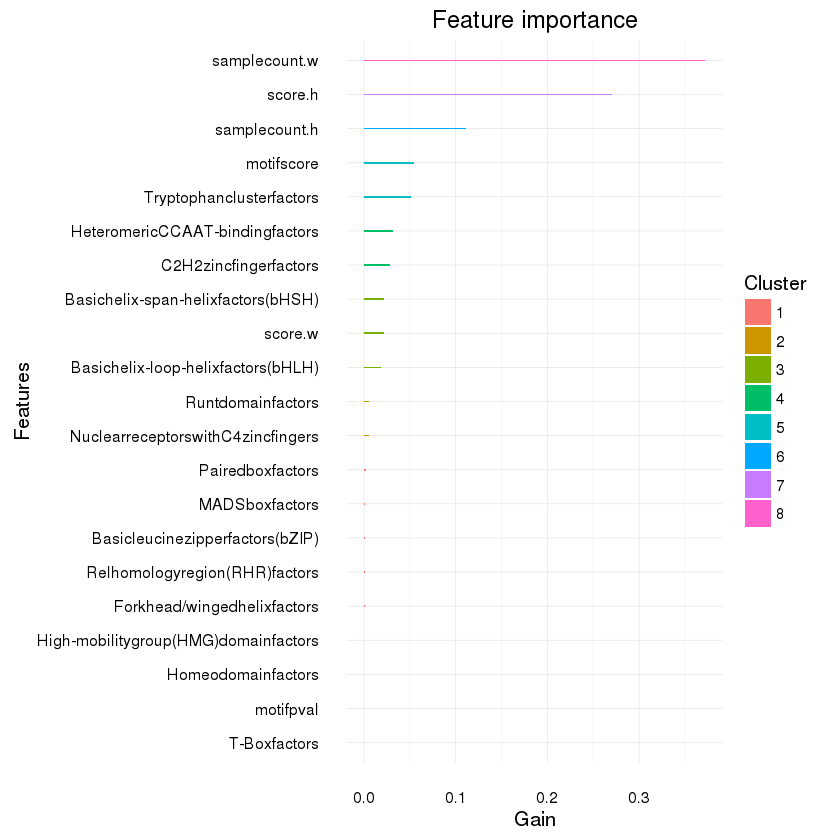

In [277]:
xgb.plot.importance(importance.matrix.smalltest) + theme_minimal()

## Train without TF Classes

In [88]:
# binarize chipseq score
y <- as.numeric(ft.subsample$csscore > 0)

# drop some more columns 
cols.to.drop <- c("csscore", "csTF", "motif", "loc", "totalsamplecount")
ft.subsample.no.tf.classes <- ft.subsample[,c(1:11)]
X <- as.matrix(ft.subsample.no.tf.classes[,!(colnames(ft.subsample.no.tf.classes) %in% cols.to.drop)])
rownames(X) <- NULL

# split into test and train sets
# train.inds <- split_data(y)

X.train <- as.matrix(X[train.inds,])
X.test <- as.matrix(X[-train.inds,])
y.train <- y[train.inds]
y.test <- y[-train.inds]

In [45]:
gbdt.small.no.tf.classes <- xgboost(
    params = param,
    data = X.train,
    label = y.train,
    nround = 250,
    verbose = FALSE,
    missing = NA
)

gbdt.small.no.tf.classes$Model.Name <- "trees no classes"

In [46]:
small.no.tf.classes.pred.df <- make.pred.df.from.model(gbdt.small.no.tf.classes, X.test, y.test)
small.no.tf.classes.stat.df <- make.stats.df.from.preds(small.no.tf.classes.pred.df, num.roc.points = 1001)

## Train a linear model on all features

In [47]:
all.regressors <- paste(colnames(X.train), collapse=" + ")
glm.formula <- paste("CHIPseq.bound ~ ", all.regressors, sep='')

glm.df.train <- as.data.frame(cbind("CHIPseq.bound"=y.train, X.train))
glm.df.test <- as.data.frame(cbind("CHIPseq.bound"=y.test, X.test))

glm.all <- glm(as.formula(glm.formula), data=glm.df.train, family=binomial)
glm.all$Model.Name <- "glm small"

In [48]:
glm.pred.df <- make.pred.df.from.glm(glm.all, glm.df.test)
glm.stat.df <- make.stats.df.from.preds(glm.pred.df, num.roc.points = 1001)

## Linear models on each feature individually

In [49]:
stats.regressors.df <- data.frame()

for (this.regressor in colnames(X.train)) {
    
    glm.formula <- paste("CHIPseq.bound ~ ", this.regressor, sep='')

    glm.df.train <- as.data.frame(cbind("CHIPseq.bound"=y.train, X.train))
    glm.df.test <- as.data.frame(cbind("CHIPseq.bound"=y.test, X.test))

    glm.single <- glm(as.formula(glm.formula), data=glm.df.train, family=binomial)
    glm.single$Model.Name <- paste("glm ", this.regressor, sep='')
    
    glm.pred.single.df <- make.pred.df.from.glm(glm.single, glm.df.test)
    glm.stat.single.df <- make.stats.df.from.preds(glm.pred.single.df, num.roc.points = 1001)
    
    stats.regressors.df <- rbind(stats.regressors.df, glm.stat.single.df)
    
}

## Plot results from all models

In [50]:
all.stats.df <- rbind(
    smalltest.stat.df,
    small.no.tf.classes.stat.df,
    glm.stat.df,
    stats.regressors.df
)

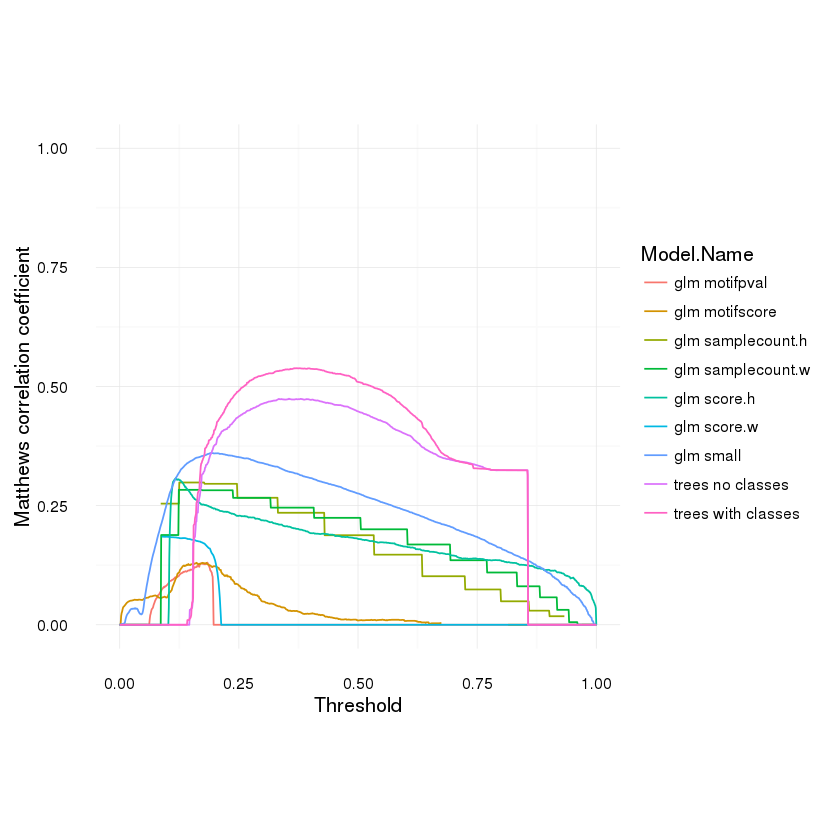

In [51]:
plot.mattcc.curve(all.stats.df)

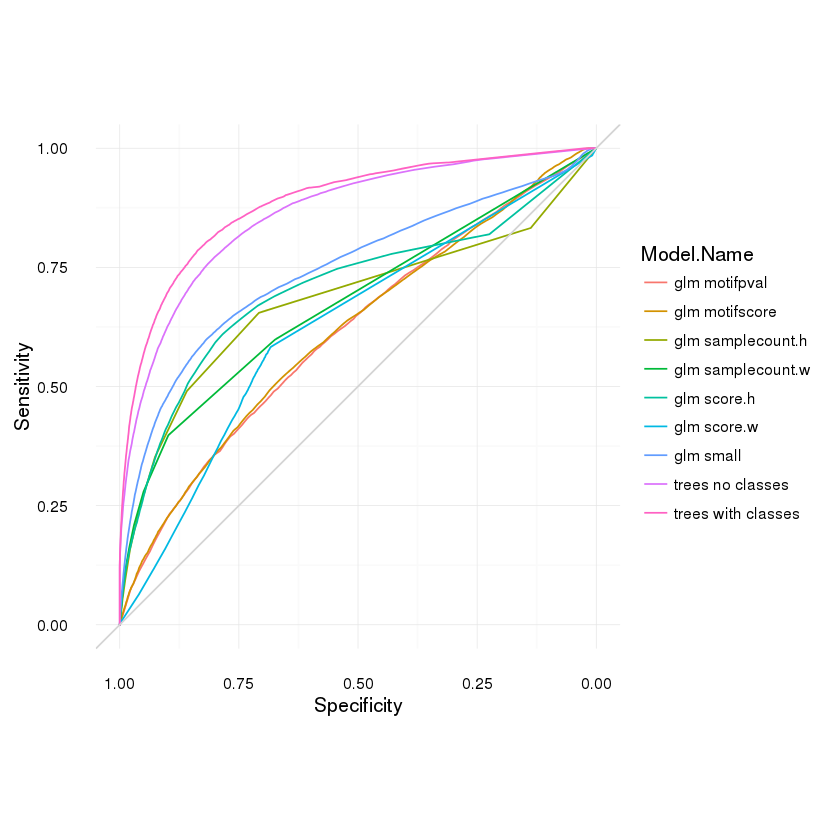

In [52]:
plot.roc.curve(all.stats.df)

Warning message:
“Removed 1927 rows containing missing values (geom_path).”

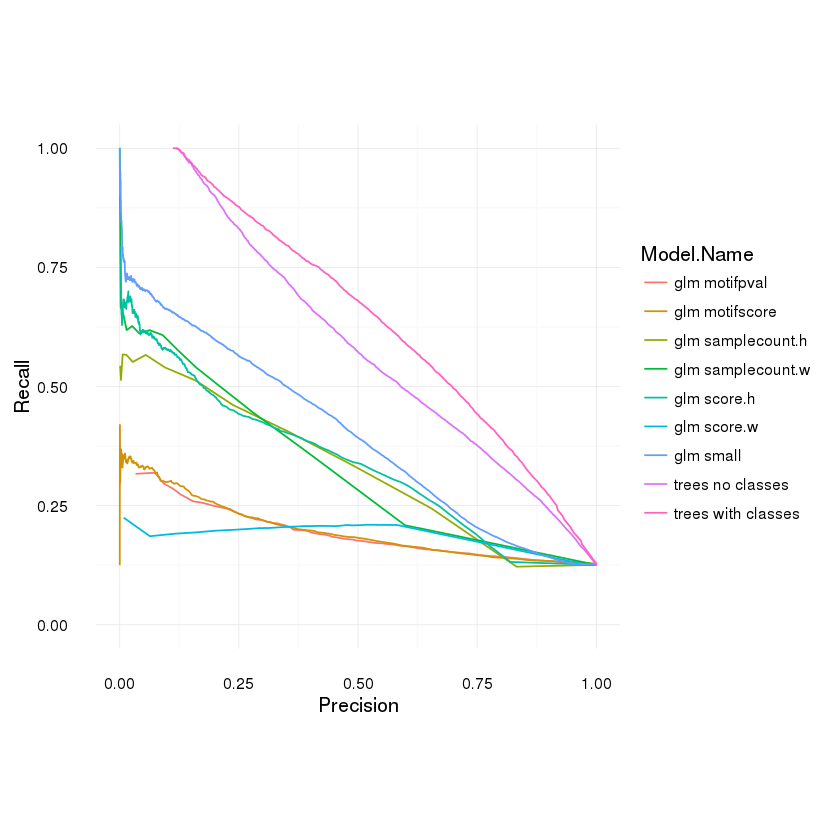

In [53]:
plot.precrecall.curve(all.stats.df)

## predict chipseq score

In [70]:
originial.size <- dim(ft.clean.corymotifs.tfclasses)[1]
sample.frac <- 1
subsample.inds <- sample(originial.size, round(sample.frac*originial.size))
ft.subsample <- ft.clean.corymotifs.tfclasses[subsample.inds,]
dim(ft.subsample)

[1] 912159     41

In [118]:
# binarize chipseq score
y <- ft.subsample$csscore

# drop some more columns 
cols.to.drop <- c("csscore", "csTF", "motif", "loc", "totalsamplecount")
X <- scale(as.matrix(ft.subsample[,!(colnames(ft.subsample) %in% cols.to.drop)]))
rownames(X) <- NULL

# split into test and train sets
train.inds <- split_data(y)

X.train <- as.matrix(X[train.inds,])
X.test <- as.matrix(X[-train.inds,])
y.train <- y[train.inds]
y.test <- y[-train.inds]

In [72]:
param <- list("objective" = "reg:linear",
          "max.depth" = 8,
          "eta" = 0.005,
          "eval.metric" = "auc"
          )

gbdt.reg <- xgboost(
    params = param,
    data = X.train,
    label = y.train,
    nround = 250,
    verbose = FALSE,
    missing = NA
)

gbdt.reg$Model.Name <- "trees with classes"

In [73]:
preds.test <- predict(gbdt.reg, X.test, missing=NA)
pred.reg.df <- data.frame("ChIPseq.score"=y.test,"Prediction"=preds.test)
pred.reg.df$Model.Name = gbdt.reg$Model.Name

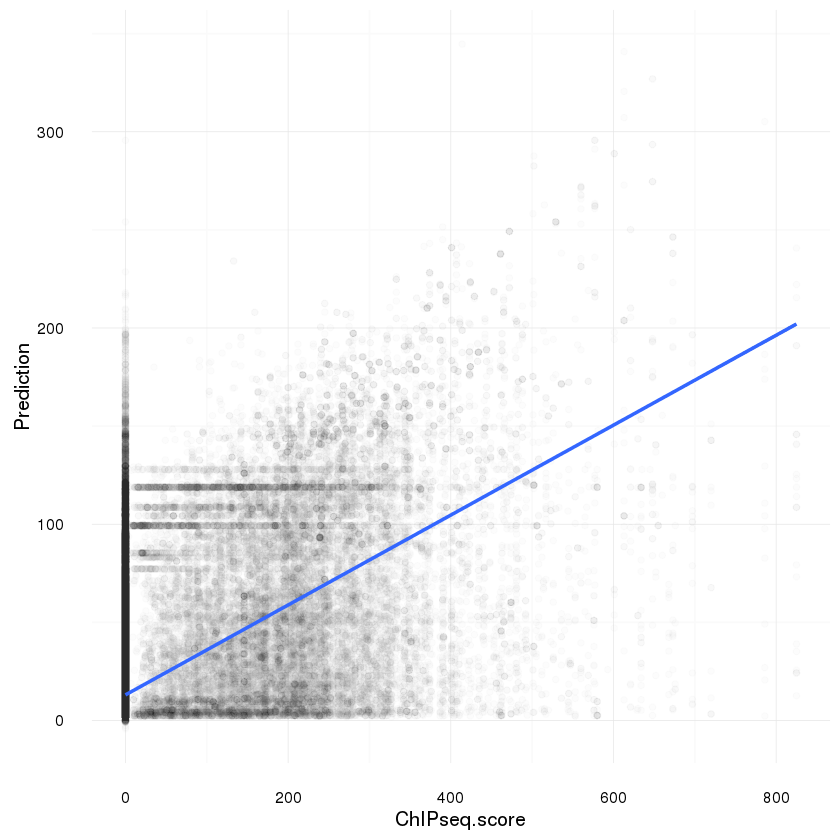

In [83]:
ggplot(pred.reg.df,aes(x=ChIPseq.score, y=Prediction)) + geom_point(alpha=0.01) +
geom_smooth(method='lm') +
theme_minimal()

In [85]:
 lm(pred.reg.df$Prediction ~ pred.reg.df$ChIPseq.score)


Call:
lm(formula = pred.reg.df$Prediction ~ pred.reg.df$ChIPseq.score)

Coefficients:
              (Intercept)  pred.reg.df$ChIPseq.score  
                  13.0249                     0.2291  


## glm regression

In [119]:
glm.formula <- "CHIPseq.score ~ samplecount.w + score.w + samplecount.h + score.h + motifscore + motifpval"

glm.df.train <- as.data.frame(cbind("CHIPseq.score"=y.train, X.train))
glm.df.test <- as.data.frame(cbind("CHIPseq.score"=y.test, X.test))

glm.reg <- glm(as.formula(glm.formula), data=glm.df.train, family = 'gaussian')
glm.reg$Model.Name <- "glm regression"

In [120]:
glm.reg.preds <- predict.glm(object=glm.reg, newdata=glm.df.test)
glm.reg.pred.df <- data.frame("ChIPseq.score"=glm.df.test$CHIPseq.score, "Prediction"=glm.reg.preds)

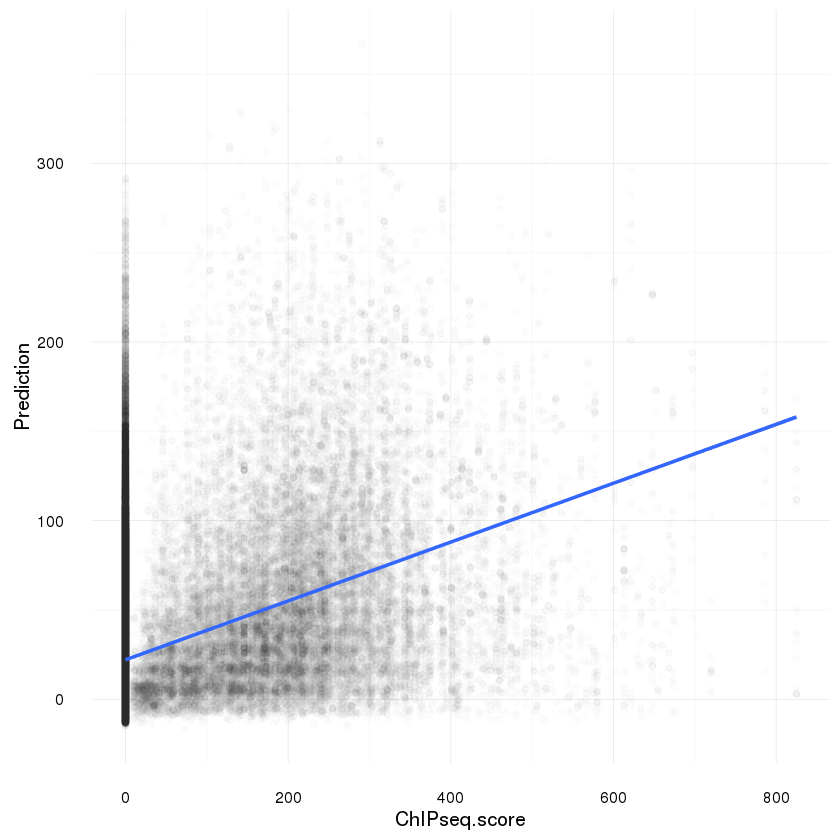

In [122]:
ggplot(glm.reg.pred.df, aes(x=ChIPseq.score, y=Prediction)) + geom_point(alpha=0.01) +
geom_smooth(method='lm') +
theme_minimal()

In [123]:
summary(glm.reg)


Call:
glm(formula = as.formula(glm.formula), family = "gaussian", data = glm.df.train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-339.40   -22.88   -13.03    -5.70   828.37  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   26.49740    0.09027 293.529  < 2e-16 ***
samplecount.w 16.79088    0.12075 139.054  < 2e-16 ***
score.w       -0.30753    0.10611  -2.898  0.00375 ** 
samplecount.h 16.43110    0.10689 153.721  < 2e-16 ***
score.h        6.57766    0.11221  58.620  < 2e-16 ***
motifscore     2.50728    0.10351  24.223  < 2e-16 ***
motifpval     -3.74443    0.10316 -36.298  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 5574.866)

    Null deviance: 4561444392  on 684118  degrees of freedom
Residual deviance: 3813833036  on 684112  degrees of freedom
AIC: 7842681

Number of Fisher Scoring iterations: 2


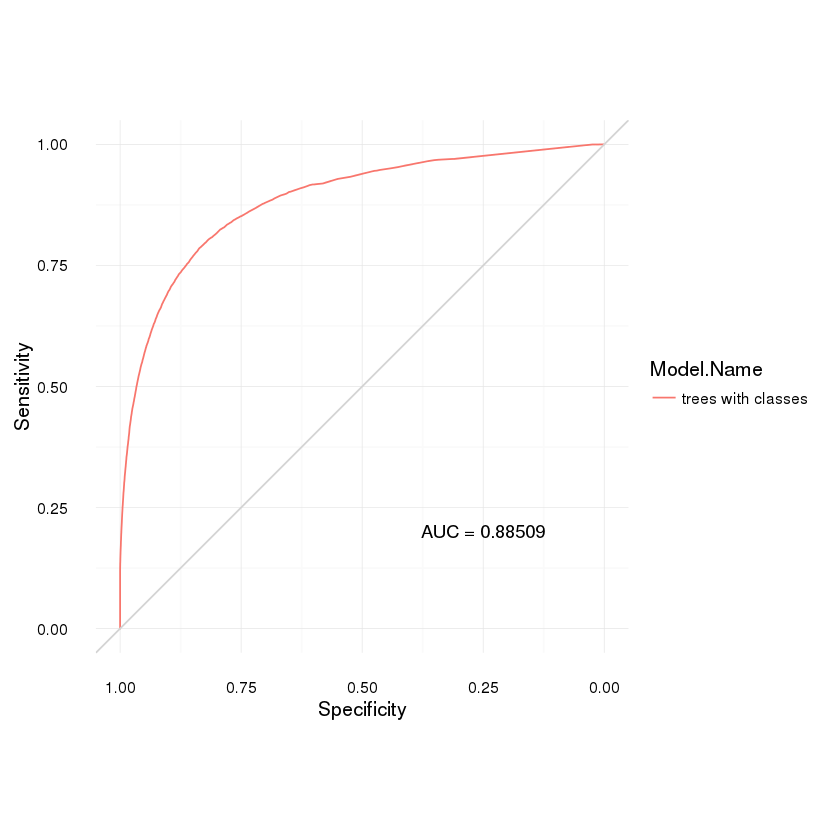

In [127]:
plot.roc.curve(smalltest.stat.df, printAUC=TRUE)

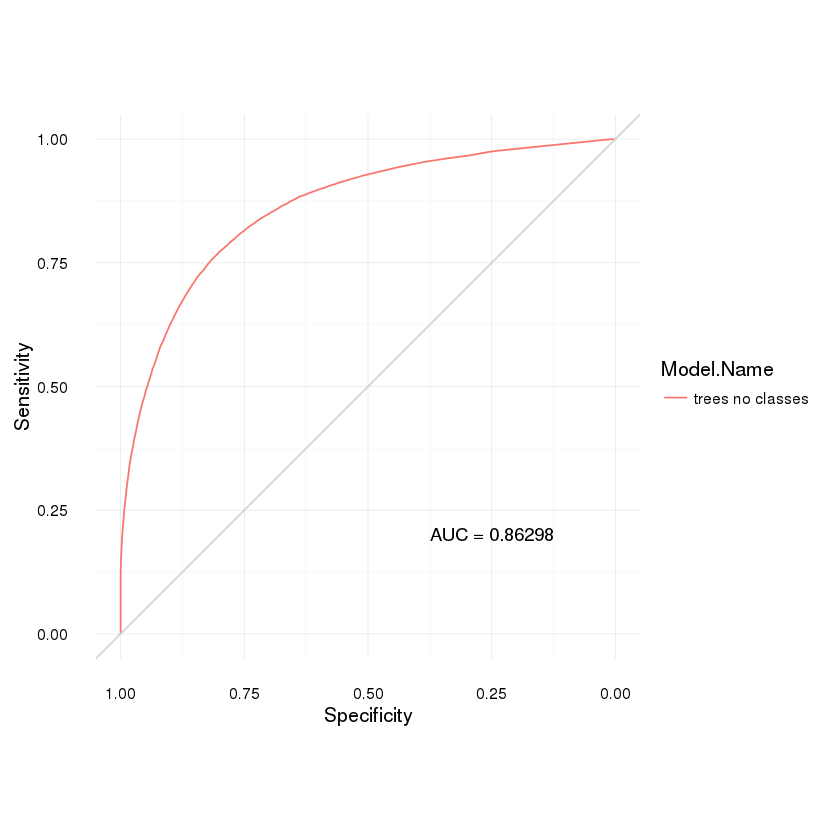

In [128]:
plot.roc.curve(small.no.tf.classes.stat.df, printAUC=TRUE)